# Notebook pour l'évaluation du corpus

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy, stanza
import langid
import os
import jupyter_black
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [29]:
jupyter_black.load()

## Chargement et analyse des données

In [30]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Charge un fichier CSV et le retourne sous forme de DataFrame

    Parameters:
    filepath (str): Le chemin du fichier CSV à charger

    Returns:
    pd.DataFrame: Le DataFrame contenant les données du fichier CSV
    """
    return pd.read_csv(filepath)


def analyze_language_distribution(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la distribution des langues dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La distribution des langues
    """
    return data["Label"].value_counts()

In [31]:
data = load_data("../../data/csv/data.csv")
print(analyze_language_distribution(data))

Label
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
ar    548
Name: count, dtype: int64


Chaque ligne montre une langue représentée par son code (par exemple, "en" pour l'anglais, "ru" pour le russe, etc.) suivi du nombre de ligne en cette langue présents dans le corpus. Voici une description plus détaillée de ces résultats :

Ayant limité le nombre maximum à 550, la majorité des langues ont ce nombre de ligne/texte. Cependant, il y a l'arabe qui compte 548 lignes/textes.


In [32]:
def analyze_text_length(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la longueur des textes dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: Les statistiques descriptives de la longueur des textes
    """
    data["Text_Length"] = data["Text"].apply(len)
    return data["Text_Length"].describe()


def plot_distributions(data: pd.DataFrame) -> None:
    """
    Affiche les distributions des langues et de la longueur des textes

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à afficher
    """
    # Appliquer le style de fond blanc
    sns.set_style("white")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y="Label", order=data["Label"].value_counts().index)
    plt.title("Distribution des langues")
    plt.xlabel("Nombre de textes")
    plt.ylabel("Langue")

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x="Text_Length", bins=30)
    plt.title("Distribution de la longueur des textes")
    plt.xlabel("Longueur du texte")
    plt.ylabel("Fréquence")

    plt.show()

count    4948.000000
mean      221.124697
std       220.553596
min         3.000000
25%        96.000000
50%       168.000000
75%       272.000000
max      3558.000000
Name: Text_Length, dtype: float64


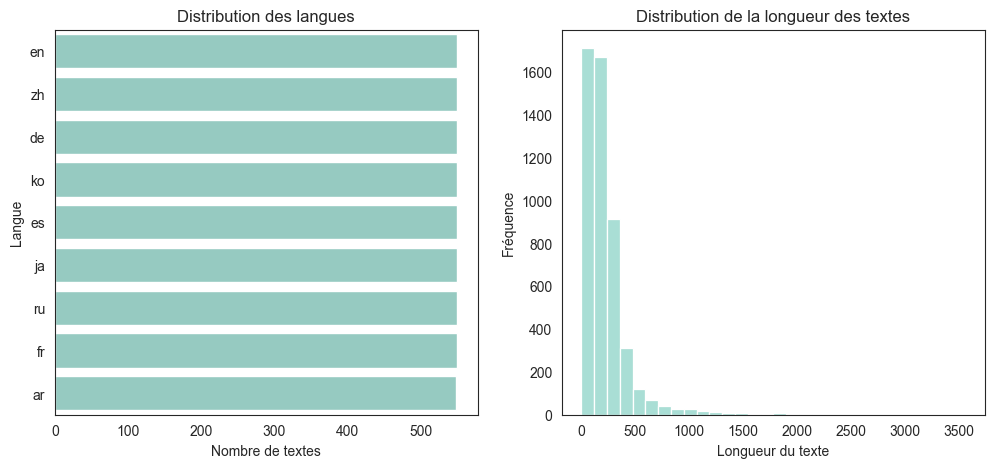

In [33]:
print(analyze_text_length(data))
plot_distributions(data)

### Analyse des Statistiques de Longueur des Textes

Voici un résumé correct des statistiques que vous avez fournies, illustrées sous forme de description textuelle pour mieux comprendre les implications :

- **Count**: 4948 textes ont été analysés, donnant une bonne taille d'échantillon pour des analyses statistiques robustes.
- **Mean**: La longueur moyenne des textes est de 221.12 caractères. Cela indique une tendance vers des textes modérément courts, ce qui est normal étant donné que pour chaque ligne il y a seulement jusqu'à 2 phrases maximum.
- **Std (Standard Deviation)**: L'écart-type est de 220.55, ce qui suggère une variation très considérable dans la longueur des textes, indiquant une distribution large.
- **Min**: Le texte le plus court fait seulement 3 caractères, ce qui pourrait être insuffisant pour certaines analyses linguistiques ou de traitement de texte.
- **25% (1st Quartile)**: 25% des textes ont 96 caractères ou moins.
- **50% (Median)**: La médiane est à 168 caractères, ce qui confirme que la moitié des textes sont assez courts.
- **75% (3rd Quartile)**: 75% des textes ont 272 caractères ou moins.
- **Max**: Le texte le plus long a 3558 caractères, montrant qu'il y a des cas où les textes sont significativement plus longs.

### Interprétation Visuelle (Graphique)
1. **Distribution des langues** : Le graphique montre que l'anglais (en) est la langue avec le plus grand nombre de textes, suivi par le chinois (zh) et l'allemand (de). Cela peut indiquer une concentration de l'échantillon sur certaines langues majeures.
2. **Distribution de la longueur des textes** : La plupart des textes sont concentrés dans les premières barres du graphique, avec une longueur de moins de 500 caractères, ce qui correspond à la description de la médiane et du premier quartile.


In [34]:
def augment_underrepresented_labels(
    data: pd.DataFrame, label_col: str, text_col: str, threshold: int
) -> pd.DataFrame:
    """
    Augmente les étiquettes sous-représentées dans un DataFrame en utilisant RandomOverSampler.

    Parameters:
    - data (pd.DataFrame): Le DataFrame contenant les colonnes de texte et d'étiquettes.
    - label_col (str): Le nom de la colonne contenant les étiquettes.
    - text_col (str): Le nom de la colonne contenant les textes.
    - threshold (int): Le seuil minimal du nombre d'échantillons par étiquette.

    Returns:
    - pd.DataFrame: Le DataFrame augmenté.
    """
    # Obtenir le nombre d'échantillons par étiquette
    label_counts = data[label_col].value_counts()

    # Créer une stratégie de sur-échantillonnage pour les étiquettes sous-représentées
    sampling_strategy = {
        label: threshold for label, count in label_counts.items() if count < threshold
    }

    # Vérifier si des étiquettes sous-représentées existent
    if not sampling_strategy:
        print("Aucune étiquette sous-représentée trouvée.")
        return data

    # Isoler les textes et les étiquettes
    X = data[[text_col]]
    y = data[label_col]

    # Utiliser RandomOverSampler pour augmenter les étiquettes sous-représentées
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Créer un nouveau DataFrame avec les données augmentées
    augmented_data = pd.DataFrame(
        {label_col: y_resampled, text_col: X_resampled[text_col]}
    )

    return augmented_data

Label
ar    550
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
Name: count, dtype: int64


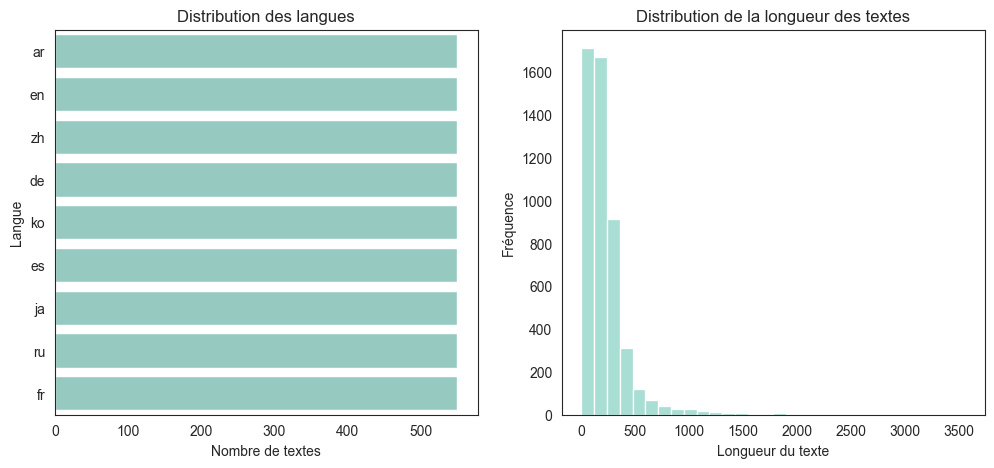

In [35]:
# Utiliser la fonction pour augmenter les étiquettes ayant moins de 550 échantillons
augmented_data = augment_underrepresented_labels(data, "Label", "Text", 550)

augmented_data.to_csv("../../data/csv/augmented_data.csv", index=False)

# Vérifier la nouvelle distribution des étiquettes
print(augmented_data["Label"].value_counts())

analyze_text_length(augmented_data)

plot_distributions(augmented_data)

In [36]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang="ar")  # Arabic


def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == "ar":
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]


def vocabulary_diversity(data: pd.DataFrame) -> pd.Series:
    """
    Calcule la diversité du vocabulaire pour chaque langue

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La diversité du vocabulaire pour chaque langue
    """
    data["Tokens"] = data.apply(lambda row: tokenize(row["Text"], row["Label"]), axis=1)
    data["Vocab_Size"] = data["Tokens"].apply(lambda x: len(set(x)))
    return data.groupby("Label")["Vocab_Size"].mean()

2024-05-09 18:40:24 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-09 18:40:24 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
INFO:stanza:Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-09 18:40:25 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-09 18:40:25 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2024-05-09 18:40:25 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2024-05-09 18:40:25 INFO: Loading: mwt
INFO:stanza:Loading: mwt
20

In [38]:
vocab_diversity = vocabulary_diversity(augmented_data)
print(vocab_diversity)

Label
ar    74.383636
de    25.018182
en    38.920000
es    36.992727
fr    38.372727
ja    40.641818
ko    25.650909
ru    28.961818
zh    36.001818
Name: Vocab_Size, dtype: float64


# Interprétation des Résultats précédents

### Analyse des Résultats
- **Arabe (ar)**: Avec une moyenne de 74.38, l'arabe montre la diversité lexicale la plus élevée parmi les langues analysées. Cela pourrait s'expliquer par la structure morphologique riche de la langue, où un nombre relativement élevé de formes de mots peut être généré à partir de racines verbales courtes.
- **Allemand (de)** et **Coréen (ko)**: Ces langues présentent les niveaux les plus faibles de diversité lexicale avec des moyennes de 25.02 et 25.65, respectivement. Cela peut indiquer un usage de vocabulaire plus standardisé ou une uniformité dans les types de textes sélectionnés pour ces langues dans le corpus.
- **Anglais (en)**, **Espagnol (es)**, **Français (fr)**, et **Chinois (zh)**: Ces langues affichent des valeurs proches les unes des autres, variant de 36.00 à 38.92, indiquant une diversité modérée. Cela suggère que les textes dans ces langues utilisent un éventail raisonnable de vocabulaire sans atteindre les extrêmes.
- **Japonais (ja)**: Affiche une valeur de 40.64, positionnant le japonais parmi les langues avec une diversité relativement élevée. Cela pourrait être attribué à l'utilisation combinée de caractères Kanji, Hiragana et Katakana, qui augmentent le nombre de mots uniques identifiés.
- **Russe (ru)**: Montre une diversité modeste avec une moyenne de 28.96. Le russe, étant une langue à inflexion riche, cette mesure peut refléter une variété modérée de formes morphologiques utilisées dans les textes.

### Implications pour la Détection de la Langue
- **Entraînement des Modèles** : La diversité lexicale élevée dans certaines langues peut poser des défis pour les modèles de traitement du langage naturel en termes de prédiction précise de la langue, surtout dans les corpus de textes courts.
- **Prétraitement et Normalisation** : Les techniques de lemmatisation et de normalisation pourraient être essentielles pour les langues avec une grande diversité lexicale pour réduire la complexité et améliorer la performance des modèles.
- **Équilibrage du Corpus** : Les résultats indiquent la nécessité d'équilibrer le corpus non seulement en termes de quantité de textes par langue mais également en termes de diversité lexicale pour minimiser les biais vers les langues avec une diversité naturellement plus élevée ou plus faible.

### Conclusion
Ces résultats soulignent l'importance d'une analyse détaillée des propriétés linguistiques spécifiques à chaque langue pour améliorer les stratégies de prétraitement et d'entraînement des modèles dans le cadre d'un système de détection de la langue efficace, en particulier pour un corpus comprenant des textes courts et multilingues.

In [39]:
def create_balanced_train_test(
    csv_path: str,
    folder_csv: str,
    label_column: str,
    test_size: float = 0.2,
    random_state: int = 42,
    ) -> None:
    """
    Cette fonction prend un fichier CSV d'entrée, le divise en ensembles d'entraînement et de test,
    et équilibre les classes dans l'ensemble d'entraînement.

    Parameters:
    csv_path (str): Le chemin du fichier CSV à charger
    folder_csv (str): Le dossier de sortie pour les fichiers CSV
    label_column (str): Le nom de la colonne contenant les étiquettes
    test_size (float): La proportion de l'ensemble de test
    random_state (int): Le générateur de nombres aléatoires pour la reproductibilité

    Returns:
    None
    """
    # Charger les données depuis le fichier CSV
    data = pd.read_csv(csv_path)

    # Diviser les données en ensembles d'entraînement et de test
    df_train, df_test = train_test_split(
        data, test_size=test_size, random_state=random_state
    )

    # Identifier la classe majoritaire dans l'ensemble d'entraînement
    majority_class = df_train[label_column].mode()[0]

    # Créer un DataFrame vide pour les données équilibrées
    balanced_train = pd.DataFrame()
    balanced_test = pd.DataFrame()

    # Rééchantillonner chaque classe
    for label in df_train[label_column].unique():
        class_subset = df_train[df_train[label_column] == label]
        balanced_subset = resample(
            class_subset,
            replace=True,
            n_samples=len(df_train[df_train[label_column] == majority_class]),
            random_state=random_state,
        )
        balanced_train = pd.concat([balanced_train, balanced_subset])

    for label in df_test[label_column].unique():
        class_subset = df_test[df_test[label_column] == label]
        balanced_subset = resample(
            class_subset,
            replace=True,
            n_samples=len(df_test[df_test[label_column] == majority_class]),
            random_state=random_state,
        )
        balanced_test = pd.concat([balanced_test, balanced_subset])

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(folder_csv, exist_ok=True)

    # Exporter les ensembles d'entraînement et de test en fichiers CSV
    balanced_train.to_csv(
        os.path.join(folder_csv, "data_train.csv"), index=False, encoding="utf-8"
    )
    balanced_test.to_csv(
        os.path.join(folder_csv, "data_test.csv"), index=False, encoding="utf-8"
    )

In [40]:
def detect_language(text: str) -> str:
    """
    Detecte la langue d'un texte

    Parameters:
    text (str): le texte à analyser

    Returns:
    str: la langue du texte
    """
    lang, _ = langid.classify(text)
    return lang


def plot_confusion_matrix(data: pd.DataFrame) -> plt.Figure:
    """
    Matrice de confusion pour la détection de la langue des textes.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    true_labels = data["Label"].tolist()
    predictions = data["Text"].apply(detect_language)
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    return fig

In [41]:
def build_and_test_model(train_csv: str, test_csv: str) -> None:
    """
    Construit un modèle de classification de texte et l'évalue en utilisant des fichiers CSV d'entraînement et de test séparés.

    Parameters:
    train_csv (str): Chemin vers le fichier CSV d'entraînement.
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données d'entraînement et de test
    train_data = pd.read_csv(train_csv)
    test_data = pd.read_csv(test_csv)

    # Remplacement des valeurs NaN par des chaînes vides
    train_data["Text"] = train_data["Text"].fillna("")
    test_data["Text"] = test_data["Text"].fillna("")

    # Vectorisation des textes
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data["Text"])
    y_train = train_data["Label"]
    X_test = vectorizer.transform(test_data["Text"])
    y_test = test_data["Label"]

    # Construction et entraînement du modèle
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Rapport de classification
    print(classification_report(y_test, y_pred))

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        confusion_matrix(y_test, y_pred, normalize="true"),
        annot=True,
        fmt=".2%",
        xticklabels=sorted(set(y_test)),
        yticklabels=sorted(set(y_test)),
        cmap="OrRd",
    )
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")

    save_path = "../../resultats/confusion_matrix.png"
    plt.savefig(save_path, facecolor="w", bbox_inches="tight")

    plt.show()

              precision    recall  f1-score   support

          ar       0.44      0.97      0.60        96
          de       0.99      0.97      0.98        96
          en       0.86      1.00      0.92        96
          es       0.93      1.00      0.96        96
          fr       0.94      1.00      0.97        96
          ja       0.82      0.34      0.49        96
          ko       0.99      0.83      0.90        96
          ru       1.00      1.00      1.00        96
          zh       0.91      0.22      0.35        96

    accuracy                           0.81       864
   macro avg       0.88      0.81      0.80       864
weighted avg       0.88      0.81      0.80       864



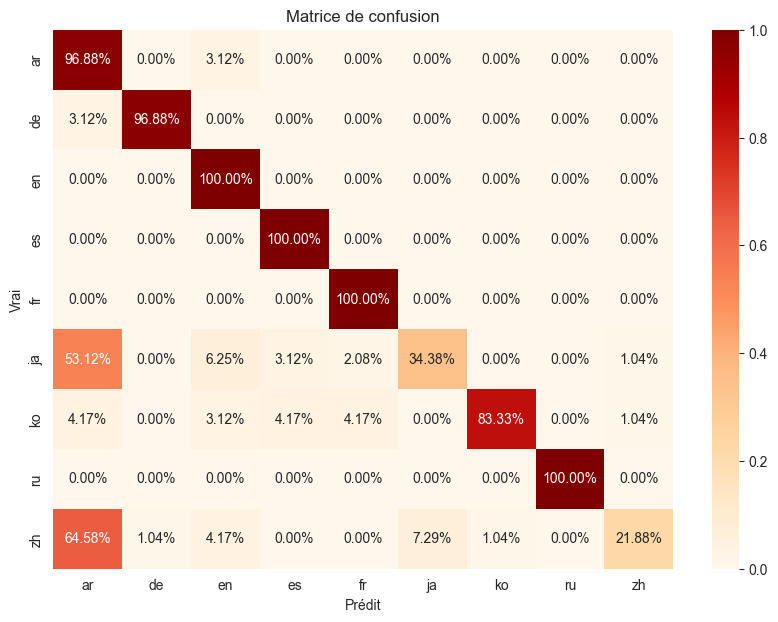

In [42]:
create_balanced_train_test(
    csv_path="../../data/csv/augmented_data.csv",
    folder_csv="../../data/csv/",
    label_column="Label",
    test_size=0.2,
    random_state=42,
)

train_csv = "../../data/csv/data_train.csv"
test_csv = "../../data/csv/data_test.csv"

build_and_test_model(train_csv, test_csv)

# Interprétation de la matrice 1

### Analyse de la Matrice de Confusion
- **Performance Globale** : Les couleurs sur la diagonale de la matrice de confusion sont majoritairement foncées, indiquant de bons taux de prédiction correcte pour la plupart des langues. Les exceptions sont le japonais (ja) et le chinois (zh) où les couleurs plus claires suggèrent des erreurs de prédiction plus fréquentes.
- **Arabe (ar)** : Bien que l'arabe montre un taux élevé de vrais positifs (96,88%), il est également souvent confondu avec l'anglais (en) à 3,12%. Cela suggère une certaine similitude ou confusion entre ces caractéristiques linguistiques dans les textes courts.
- **Allemand (de)** : Excellent taux de prédiction à 96,88%, avec un faible taux de confusion avec l'arabe (3,12%).
- **Anglais (en), Espagnol (es), Français (fr)** : Ces langues montrent une précision de prédiction parfaite de 100%, ce qui indique que le modèle les distingue très bien des autres langues.
- **Japonais (ja)** : Montre une performance médiocre avec seulement 34,38% de prédiction correcte, avec des confusions notables avec l'arabe (53,12%), l'anglais (6,25%), l'espagnol (3,12%), le français (2,08%) et le chinois avec 1,04%.
- **Coréen (ko)** : Bonne prédiction à 83,33%, mais avec des erreurs mineures partagées avec d'autres langues, l'arabe, l'espagnol, le français (4,17%), l'anglais (3,12%) et le chinois (1,04%).
- **Russe (ru)** : Performance parfaite avec 100% de prédiction correcte, sans aucune confusion avec d'autres langues.
- **Chinois (zh)** : Faible taux de prédiction correcte à 21,88%, avec une confusion majeure avec l'arabe (64,58%) puis le japonais (7,29%), l'anglais (4,17%) et l'allemand et le coréen (1,04%).

### Analyse des Scores de Classification
- **Précision** : La précision est excellente pour le russe (1.00), l'allemand (0.99), et le coréen (0.99), ce qui indique que lorsque ces langues sont prédites, elles sont très probablement correctes. L'arabe, cependant, a une précision très faible de 0.44, ce qui signifie que de nombreuses prédictions fausses positives sont faites pour cette langue, reflétant une confusion avec d'autres langues dans le modèle.
  
- **Rappel** : Le rappel est parfait (1.00) pour l'anglais, l'espagnol, le français et le russe, indiquant que tous les textes de ces langues sont correctement identifiés. Le rappel pour le chinois est particulièrement bas à 0.22, ce qui signifie que beaucoup de textes chinois sont incorrectement classifiés comme d'autres langues.
  
- **Score F1** : Le score F1 est particulièrement utile pour évaluer l'équilibre entre la précision et le rappel. Par exemple, malgré le rappel élevé pour l'arabe, son score F1 est seulement de 0.60 à cause de la faible précision. Le japonais et le chinois montrent des scores F1 très faibles (0.49 et 0.35, respectivement), ce qui met en évidence une performance globale médiocre pour ces langues, nécessitant une attention particulière pour améliorer le modèle.

### Conclusion

L'analyse de la matrice de confusion et des scores de classification révèle que, si le modèle de détection de langue est très performant pour des langues comme le russe, l'allemand, le français, l'anglais, et l'espagnol, il présente des déficiences significatives avec le japonais et le chinois. Les faibles scores F1 pour ces deux langues suggèrent des problèmes de classification qui nécessitent une attention particulière.


              precision    recall  f1-score   support

          ar       1.00      1.00      1.00        96
          de       1.00      0.93      0.96        96
          en       0.96      1.00      0.98        96
          es       1.00      1.00      1.00        96
          fr       1.00      1.00      1.00        96
          ja       0.99      0.96      0.97        96
          ko       1.00      1.00      1.00        96
          ru       1.00      1.00      1.00        96
          zh       0.93      0.99      0.96        96

    accuracy                           0.99       864
   macro avg       0.99      0.99      0.99       864
weighted avg       0.99      0.99      0.99       864



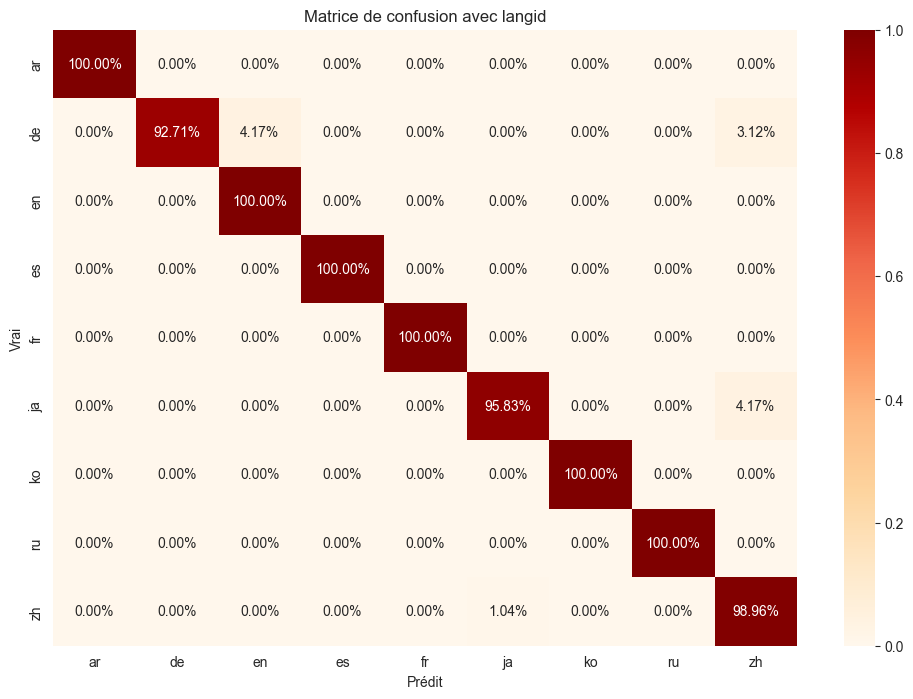

In [43]:
def build_and_test_model_with_langid(test_csv: str) -> None:
    """
    Construit un modèle de classification de texte utilisant langid pour la prédiction de la langue,
    en configurant langid pour détecter uniquement les langues présentes dans les étiquettes de données de test.

    Parameters:
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données de test
    test_data = pd.read_csv(test_csv)
    test_data["Text"] = test_data["Text"].fillna(
        ""
    )  # Remplacement des valeurs NaN par des chaînes vides

    # Extraire les langues uniques à partir des étiquettes
    languages = sorted(test_data["Label"].unique())
    langid.set_languages(
        languages
    )  # Configurer langid pour limiter la détection aux langues spécifiées

    # Prédiction des langues avec langid
    predictions = [langid.classify(text)[0] for text in test_data["Text"]]
    test_data["Predicted"] = predictions

    # Obtention des ensembles de labels uniques
    unique_labels = sorted(set(test_data["Label"]))
    unique_predictions = sorted(set(test_data["Predicted"]))

    # Union des labels et des prédictions pour couvrir toutes les possibilités
    all_langs = sorted(set(unique_labels + unique_predictions))

    print(
        classification_report(
            test_data["Label"],
            test_data["Predicted"],
            labels=all_langs,
            zero_division=0,
        )
    )

    # Création de la matrice de confusion
    cm = confusion_matrix(
        test_data["Label"], test_data["Predicted"], labels=all_langs, normalize="true"
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2%",
        cmap="OrRd",
        xticklabels=all_langs,
        yticklabels=all_langs,
    )
    plt.title("Matrice de confusion avec langid")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")

    save_path = "../../resultats/confusion_matrix_with_langid.png"
    plt.savefig(save_path, facecolor="w", bbox_inches="tight")

    plt.show()


build_and_test_model_with_langid(test_csv)

# Interprétation de la matrice 2

### Analyse de la Matrice de Confusion avec LangID

Cette matrice de confusion montre des résultats globalement excellents pour la détection de la langue à l'aide du modèle LangID, avec des taux élevés de prédiction correcte pour presque toutes les langues. Voici une interprétation détaillée :

- **Arabe (ar)** : Parfaite identification avec 100% de prédiction correcte, ce qui indique une excellente distinction de cette langue par le modèle.
- **Allemand (de)** : Très bon score avec 92.71% de prédiction correcte. Il y a une petite confusion avec le chinois (zh) à 3.12% et avec l'anglais (en) à 4.17%.
- **Anglais (en)** : Précision de prédiction parfaite à 100%, montrant une capacité robuste du modèle à identifier l'anglais sans aucune confusion.
- **Espagnol (es)** : Comme l'anglais, l'espagnol est parfaitement identifié avec 100% de prédiction correcte.
- **Français (fr)** : Performance également parfaite avec 100% de taux de prédiction correcte, démontrant la clarté des caractéristiques linguistiques du français pour le modèle.
- **Japonais (ja)** : Très bonne prédiction à 95.83%, avec une petite confusion avec le chinois (zh) à 4.17%, probablement due à l'utilisation de caractères kanji communs aux deux langues.
- **Coréen (ko)** : Excellente identification avec 100% de prédiction correcte, indiquant une détection très précise par le modèle.
- **Russe (ru)** : Comme plusieurs autres langues, le russe a un score parfait de 100%, sans confusion avec d'autres langues.
- **Chinois (zh)** : Très haute prédiction correcte à 98.96%, avec une légère confusion avec le japonais (ja) à 1.04%. 

### Scores de Précision, Rappel et F1
- **Précision et Rappel** : La plupart des langues affichent des scores de précision et de rappel extrêmement élevés, souvent parfaits (1.00). L'allemand et le chinois ont des scores légèrement plus bas, mais restent très élevés, ce qui indique une forte capacité de distinction du modèle pour ces langues.
- **Score F1** : Les scores F1 sont proches de la perfection pour la plupart des langues, reflétant un excellent équilibre entre la précision et le rappel. Même pour les langues avec une légère confusion, comme le japonais et le chinois, les scores F1 sont très élevés, indiquant des performances globales robustes.

### Conclusion
Cette analyse met en évidence l'efficacité du modèle LangID dans la détection précise de diverses langues, avec des performances exceptionnelles pour presque toutes les langues testées. Les quelques cas de confusion sont mineurs et ne diminuent pas significativement l'efficacité globale du modèle.

# Comparaison des deux matrices de confusion et de leurs résultats associés :
La comparaison entre les deux matrices de confusion et leurs résultats associés illustre l'impact significatif de l'intégration de la technologie LangID sur l'amélioration des performances de détection de langue.

1. **Première Matrice de Confusion (Sans LangID)**
   - **Performances Générales** : Cette matrice montre une précision globale moyenne de 81%, avec des performances variables entre les langues. Notamment, le japonais (ja) et le chinois (zh) montrent des taux de rappel particulièrement faibles, indiquant des difficultés significatives dans la classification correcte de ces langues.
   - **Problèmes Spécifiques** :
     - **Japonais (ja)** : Faible rappel de 34%, principalement confondu avec l'arabe (53.12%) et d'autres langues asiatiques, soulignant une grande confusion inter-langues.
     - **Chinois (zh)** : Rappel très faible à 22%, majoritairement confondu avec l'arabe (64.58%), reflétant des problèmes significatifs de classification.

2. **Deuxième Matrice de Confusion (Avec LangID)**
   - **Performances Générales** : Précision élevée avec une exactitude globale de 99%, montrant une amélioration substantielle dans la distinction des langues par rapport à la première matrice.
   - **Problèmes Spécifiques** :
     - **Allemand (de)** : Bien que très précis à 92.71%, montre une légère confusion avec l'anglais (4.17%) et le chinois (3.12%), mais avec une amélioration notable par rapport à la première matrice.
     - **Chinois (zh)** : Amélioration considérable avec un rappel à 99%, démontrant une capacité accrue du modèle à distinguer correctement le chinois des autres langues, surtout par rapport à sa performance précédente.

### Comparaison et Conclusion :
- **Amélioration avec LangID** : L'introduction de LangID dans la deuxième matrice a nettement amélioré les performances du modèle, réduisant les confusions inter-langues et augmentant la précision et le rappel pour presque toutes les langues. Cela est particulièrement vrai pour les langues qui présentaient auparavant des défis majeurs, comme le japonais et le chinois.
- **Implications pour le Traitement NLP** : L'utilisation d'un outil comme LangID peut considérablement réduire les erreurs dans les tâches de classification de langue, crucial pour des applications pratiques telles que la traduction automatique ou le filtrage de contenu.
- **Analyse pour l'Amélioration** : L'analyse des erreurs restantes, même minimes, peut aider à affiner davantage les modèles ou les techniques de prétraitement pour cibler des confusions spécifiques qui persistent même avec des aides technologiques comme LangID.
